In [ ]:
# default_exp fit

# fullstream.fit

> Module that wraps constrained + global fitters in a differentiable form using the module fax. Uses the two-phase-solver.

In [ ]:
# export
import jax
from fax.implicit import twophase

from fullstream.transforms import *

In [ ]:
# export
def get_solvers(
    model_constructor,
    pdf_transform=False,
    default_rtol=1e-10,
    default_atol=1e-10,
    default_max_iter=1000000,
):
    def make_model(hyper_pars):
        constrained_mu, nn_pars = hyper_pars[0], hyper_pars[1]
        m, bonlypars = model_constructor(nn_pars)

        bounds = m.config.suggested_bounds()

        exp_bonly_data = m.expected_data(bonlypars, include_auxdata=True) + 0.2

        def expected_logpdf(pars):  # maps pars to bounded space if pdf_transform = True

            return (
                m.logpdf(transform_lim_vec(pars, bounds), exp_bonly_data)
                if pdf_transform
                else m.logpdf(pars, exp_bonly_data)
            )

        def global_fit_objective(pars):  # NLL
            return -expected_logpdf(pars)[0]

        def constrained_fit_objective(nuis_par):  # NLL
            pars = jax.numpy.concatenate(
                [jax.numpy.asarray([constrained_mu]), nuis_par]
            )
            return -expected_logpdf(pars)[0]

        return constrained_mu, global_fit_objective, constrained_fit_objective

    def global_bestfit_minimized(hyper_param):
        _, nll, _ = make_model(hyper_param)

        def bestfit_via_grad_descent(i, param):  # gradient descent
            param = param - jax.grad(nll)(param) * 0.01
            return param

        return bestfit_via_grad_descent

    def constrained_bestfit_minimized(hyper_param):
        mu, nll, cnll = make_model(hyper_param)

        def bestfit_via_grad_descent(i, param):  # gradient descent
            _, np = param[0], param[1:]
            np = np - jax.grad(cnll)(np) * 0.01
            param = jax.numpy.concatenate([jax.numpy.asarray([mu]), np])
            return param

        return bestfit_via_grad_descent

    global_solve = twophase.two_phase_solver(
        param_func=global_bestfit_minimized,
        default_rtol=default_rtol,
        default_atol=default_atol,
        default_max_iter=default_max_iter,
    )
    constrained_solver = twophase.two_phase_solver(
        param_func=constrained_bestfit_minimized,
        default_rtol=default_rtol,
        default_atol=default_atol,
        default_max_iter=default_max_iter,
    )

    def g_fitter(init, hyper_pars):
        return global_solve(init, hyper_pars).value

    def c_fitter(init, hyper_pars):
        return constrained_solver(init, hyper_pars).value

    return g_fitter, c_fitter

#### getting test

In [ ]:
from fullstream.models import nn_model_maker

g_fitter, c_fitter = get_solvers(nn_model_maker)

#### non-transformed fit test


Starting training...
Epoch 0 in 2.74 sec
Training set accuracy 0.8476
model: [ 6.40477037 13.59522963],[43.13707402  6.86292598],[4.44113382 4.44113382]
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
constrained fit: [1.         0.96071416]
global fit: [0.01694888 1.0021199 ]


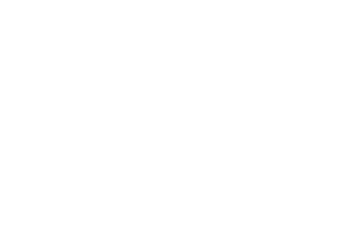

In [ ]:
from fullstream.nn import three_blob_classifier

x = three_blob_classifier()
_ = x.train(num_epochs=1)
nn_params = x.params

g_fitter, c_fitter = get_solvers(nn_model_maker, pdf_transform=False)

m, bonlypars = nn_model_maker(nn_params)
exp_data = m.expected_data(bonlypars)
bounds = m.config.suggested_bounds()

test_mu = 1.0

# map these
initval = jax.numpy.asarray([test_mu, 1.0])
# the constrained fit
numerator = c_fitter(initval, [test_mu, nn_params])
# the global fit
denominator = g_fitter(initval, [test_mu, nn_params])

print(f"constrained fit: {numerator}")
print(f"global fit: {denominator}")

#print(f"transformed constrained fit: {transform_lim_vec(numerator,bounds)}")
#print(f"transformed global fit: {transform_lim_vec(denominator,bounds)}")

#### transformed fit test

In [ ]:
g_fitter, c_fitter = get_solvers(nn_model_maker, pdf_transform=True)

m, bonlypars = nn_model_maker(nn_params)
exp_data = m.expected_data(bonlypars)
bounds = m.config.suggested_bounds()

test_mu = 1.0

initval = jax.numpy.asarray([test_mu, 1.0])

# transform everything to inf space
initval = inv_transform_lim_vec(initval, bounds)
init_test_mu = inv_transform_lim(test_mu, bounds[0])

# do fits, then transform answers to bounded space
numerator = transform_lim_vec(c_fitter(initval, [init_test_mu, nn_params]), bounds)
denominator = transform_lim_vec(g_fitter(initval, [init_test_mu, nn_params]), bounds)

print(f"constrained fit: {numerator}")
print(f"global fit: {denominator}")

model: [ 6.40477037 13.59522963],[43.13707402  6.86292598],[4.44113382 4.44113382]
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
constrained fit: [ 1. 10.]
global fit: [0.         0.59398947]
